In [1]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import os

minmag = 4.3

# Tunguska
project = 'summer23'
project_dir = '/hdd/Ridgecrest/' + project + '/'

# Valdivia
# project_dir = '/home/sdybing/gnss-picker/data/realdata/'

tt_files_dir = project_dir + 'minM' + str(minmag) + '_seismic_traveltimes_w_stainfo/' # Loc of seismic traveltimes
p_tt_dir = tt_files_dir + 'p_tts/' # Where are the P-wave travel time calculations

gnss_tt_dir = project_dir + 'minM' + str(minmag) + '_gnss_traveltimes/' # Where to save the GNSS tts
gnss_tt_p_dir = gnss_tt_dir + 'p_tts/'
interpolation_plot_dir = gnss_tt_dir + 'interpolation_plots/'
interpplot_p_dir = interpolation_plot_dir + 'p_plots/'

if os.path.isdir(gnss_tt_dir):
    pass
else:
    os.makedirs(gnss_tt_dir)
    os.makedirs(gnss_tt_p_dir)
    os.makedirs(interpolation_plot_dir)
    os.makedirs(interpplot_p_dir)

event_catalog = np.genfromtxt(project_dir + 'minM' + str(minmag) + '_event_catalog.txt', dtype = 'U')
event_IDs = event_catalog[:,0]
GNSS_stas = np.genfromtxt(project_dir + 'GNSS_stas.txt', dtype = 'U')
GNSS_min_lon = float(min(GNSS_stas[:,0]))
GNSS_max_lon = float(max(GNSS_stas[:,0]))
GNSS_min_lat = float(min(GNSS_stas[:,1]))
GNSS_max_lat = float(max(GNSS_stas[:,1]))

counter = 0

small_test = False # Test code with smaller dataset?
resume = False

if small_test:
    event_catalog = event_catalog[23:24,:]
    p = np.where(GNSS_stas[:,2] == 'BEPK')[0]
    q = np.where(GNSS_stas[:,2] == 'P740')[0]
    r = np.where(GNSS_stas[:,2] == 'DLUZ')[0]
    
if resume:
    resume_row = 31 # Printout number it stopped at minus 1
    counter = resume_row
    event_catalog = event_catalog[resume_row:,:]

Event 37451589 (1/362)
Error for this event
Event 37451541 (2/362)
Error for this event
Event 37451501 (3/362)
Error for this event
Event 37451477 (4/362)
Error for this event
Event 37451309 (5/362)
Error for this event
Event 37451149 (6/362)
Error for this event
Event 37450997 (7/362)
Error for this event
Event 37450989 (8/362)
Error for this event
Event 37450933 (9/362)
Error for this event
Event 37450925 (10/362)
Error for this event
Event 37450917 (11/362)
Error for this event
Event 37450909 (12/362)
Error for this event
Event 37450901 (13/362)
Error for this event
Event 37450893 (14/362)
Error for this event
Event 37450717 (15/362)
Error for this event
Event 37450613 (16/362)
Error for this event
Event 37450605 (17/362)
Error for this event
Event 37450597 (18/362)
Error for this event
Event 38592034 (19/362)
Error for this event
Event 37450541 (20/362)
Error for this event
Event 37450309 (21/362)
Error for this event
Event 37449909 (22/362)
Error for this event
Event 37449877 (23/

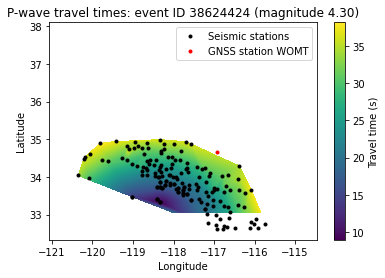

In [2]:
for kevent in range(len(event_catalog)):
    
    counter += 1

    event_ID = event_catalog[kevent,0]
    mag = event_catalog[kevent,5]
    
#     print('----------------------')
    print('Event ' + str(event_ID) + ' (' + str(counter) + '/' + str(len(event_IDs)) + ')')
    
    plot_event_dir = interpplot_p_dir + event_ID + '/'
    
    if os.path.isdir(plot_event_dir):
        pass
    else:
        os.makedirs(plot_event_dir)

    try:        
        
        P_array = np.load(p_tt_dir + str(event_ID) + '.npy')

        ###### Interpolate P-wave pick times ######

        P_latitude = np.asfarray(P_array[:,2])
        P_longitude = np.asfarray(P_array[:,3])
        P_travel_times = np.asfarray(P_array[:,4])

        P_interp_lat = np.linspace(GNSS_min_lat, GNSS_max_lat, num = 1000)
        P_interp_lon = np.linspace(GNSS_min_lon, GNSS_max_lon, num = 1000)

        P_interp_lon, P_interp_lat = np.meshgrid(P_interp_lon, P_interp_lat)

        P_interp = LinearNDInterpolator(list(zip(P_longitude, P_latitude)), P_travel_times)

        P_interp_tt = P_interp(P_interp_lon, P_interp_lat)

        ### Find values for GNSS stations ###

        GNSS_stas = np.genfromtxt(project_dir + 'GNSS_stas.txt', dtype = 'U')

        if small_test:  
            GNSS_stas = GNSS_stas[[p,q,r],:][:,0,:]

        GNSS_stacodes = GNSS_stas[:,2]

        GNSS_P_tts = []
        GNSS_P_stas = []
        P_event_IDs = []
        P_dists_to_interp_pt_deg = []

        for kGsta in range(len(GNSS_stacodes)):

            P_dists = []
            lon_list = []
            lat_list = []

            GNSS_stacode = GNSS_stas[kGsta,2]
#             print('--- ' + str(GNSS_stacode) + ' ---')
            GNSS_lon = float(GNSS_stas[kGsta,0])
            GNSS_lat = float(GNSS_stas[kGsta,1])

#             print('GNSS station location: (' + str(GNSS_lat) + ', ' + str(GNSS_lon) + ')')

            for i_lon in P_interp_lon[0]:
                # print(i_lon)
                for i_lat in P_interp_lat[:,0]:
                    # print(i_lat)
                    dist = np.sqrt((GNSS_lon - i_lon)**2 + (GNSS_lat - i_lat)**2)

                    P_dists.append(dist)
                    lon_list.append(i_lon)
                    lat_list.append(i_lat)

            P_dists = np.array(P_dists)
            lon_array = np.array(lon_list)
            lat_array = np.array(lat_list)   
            i = np.argmin(P_dists)

#             print('Distance (km) to closest interpolated point: ' + str(round(P_dists[i] * 111, 1)))
#             print('Interpolated point location: (' + str(lat_array[i]) + ', ' + str(lon_array[i]) + ')')

            a = np.where(P_interp_lon[0] == lon_array[i])[0]
            b = np.where(P_interp_lat[:,0] == lat_array[i])[0]
            GNSS_time = P_interp_tt[b,a][0]
#             print('Interpolated GNSS travel time: ' + str(round(GNSS_time, 2)))

            GNSS_P_tts.append(GNSS_time)
            GNSS_P_stas.append(GNSS_stacode)
            P_event_IDs.append(event_ID)

            plt.figure(num = 1, clear = True)
            plt.pcolormesh(P_interp_lon, P_interp_lat, P_interp_tt, shading = 'auto')
            plt.plot(P_longitude, P_latitude, '.k', label = 'Seismic stations')
            plt.plot(GNSS_lon, GNSS_lat, '.', color = 'red', label = 'GNSS station ' + GNSS_stacode)
            plt.plot()
            plt.legend()
            plt.colorbar(label = 'Travel time (s)')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title('P-wave travel times: event ID ' + str(event_ID) + ' (magnitude ' + str(mag) + ')')
#             plt.show()
            plt.savefig(plot_event_dir + str(GNSS_stacode) + '.png', format = 'PNG')
#             plt.close()
            
        GNSS_P_array = np.column_stack((np.array(P_event_IDs), np.array(GNSS_P_stas), np.array(GNSS_P_tts)))
        np.save(gnss_tt_p_dir + str(event_ID) + '.npy', GNSS_P_array)
        
    except:
        
        print('Error for this event')
        nan_P_array = np.column_stack(('nan', 'nan', 'nan'))
        np.save(gnss_tt_p_dir + str(event_ID) + '.npy', nan_P_array)